In [1]:
import functools
from typing import Literal, Optional

import jax
import jax.numpy as jnp
import numpy as np
import optax
import scanpy as sc
from flax import linen as nn
from flax.training import train_state
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, genot
from ott.neural.networks.layers import time_encoder
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm

from ot_pert.utils import ConditionalLoader
from ot_pert.nets.nets import GENOTVelocityFieldWithAttention

In [2]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray],
    tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray],
    tgt_quad: Optional[jnp.ndarray],
    *,
    typ: Literal["lin", "quad", "fused"],
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(x=src_lin, y=tgt_lin, scale_cost="mean")
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin)
    raise NotImplementedError(f"Unknown type: {typ}.")


adata_train = sc.read("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train.h5ad")
dls = []
source = adata_train[adata_train.obs["condition"] == "control"].obsm["X_pca"]

for cond in adata_train.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_train[adata_train.obs["condition"] == cond].obsm["X_pca"]
    condition_1 = adata_train[adata_train.obs["condition"] == cond].obsm["ecfp_drug_1"]
    condition_2 = adata_train[adata_train.obs["condition"] == cond].obsm["ecfp_drug_2"]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(
        np.concatenate((condition_1[0, :][None, :], condition_2[0, :][None, :]), axis=0), axis=0
    )
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    dls.append(
        DataLoader(
            datasets.OTDataset(
                datasets.OTData(
                    lin=source,
                    condition=conds,
                ),
                datasets.OTData(lin=target),
            ),
            batch_size=1024,
            shuffle=True,
        )
    )

train_loader = ConditionalLoader(dls, seed=0)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
2024-04-24 14:27:51.054036: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = condition_1.shape[1]

vf = GENOTVelocityFieldWithAttention(
    split_dim=source_dim,
    num_heads=1,
    qkv_feature_dim=32,
    max_seq_length=2,
    hidden_dims=[1024, 1024, 1024],
    output_dims=[1024, 1024, 1024, target_dim],
    condition_dims=[512, 512],
    condition_dims_forward=[512, 512],
    condition_dims_post_attention=[64, 64],
    time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
    dropout_rate=0.1
)

In [4]:
model = genot.GENOT(
    vf,
    flow=dynamics.ConstantNoiseFlow(0.0),
    data_match_fn=jax.jit(functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None)),
    source_dim=source_dim,
    target_dim=target_dim,
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 20),
)

In [5]:
training_logs = {"loss": []}
s_divs_valid = []
valid_freq = 10000

In [6]:
from typing import Dict, Tuple


def prepare_data(
    batch: Dict[str, jnp.ndarray],
) -> Tuple[
    Tuple[jnp.ndarray, Optional[jnp.ndarray], jnp.ndarray],
    Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray], Optional[jnp.ndarray]],
]:
    src_lin, src_quad = batch.get("src_lin"), batch.get("src_quad")
    tgt_lin, tgt_quad = batch.get("tgt_lin"), batch.get("tgt_quad")

    if src_quad is None and tgt_quad is None:  # lin
        src, tgt = src_lin, tgt_lin
        arrs = src_lin, tgt_lin
    elif src_lin is None and tgt_lin is None:  # quad
        src, tgt = src_quad, tgt_quad
        arrs = src_quad, tgt_quad
    elif all(arr is not None for arr in (src_lin, tgt_lin, src_quad, tgt_quad)):  # fused quad
        src = jnp.concatenate([src_lin, src_quad], axis=1)
        tgt = jnp.concatenate([tgt_lin, tgt_quad], axis=1)
        arrs = src_quad, tgt_quad, src_lin, tgt_lin
    else:
        raise RuntimeError("Cannot infer OT problem type from data.")

    return (src, batch.get("src_condition"), tgt), arrs

In [7]:
import jax.tree_util as jtu

In [8]:
rng = jax.random.PRNGKey(0)
for it in tqdm(range(1000)):
    batch = next(iter(train_loader))
    batch = jtu.tree_map(jnp.asarray, batch)
    rng = jax.random.split(rng, 5)
    rng, rng_resample, rng_noise, rng_time, rng_step_fn = rng

    batch = jtu.tree_map(jnp.asarray, batch)
    (src, src_cond, tgt), matching_data = prepare_data(batch)

    n = src.shape[0]
    time = model.time_sampler(rng_time, n * model.n_samples_per_src)
    latent = model.latent_noise_fn(rng_noise, (n, model.n_samples_per_src))

    tmat = model.data_match_fn(*matching_data)  # (n, m)
    src_ixs, tgt_ixs = solver_utils.sample_conditional(  # (n, k), (m, k)
        rng_resample,
        tmat,
        k=model.n_samples_per_src,
    )

    src, tgt = src[src_ixs], tgt[tgt_ixs]  # (n, k, ...),  # (m, k, ...)
    if src_cond is not None:
        src_cond = src_cond[src_ixs]

    if model.latent_match_fn is not None:
        src, src_cond, tgt = model._match_latent(rng, src, src_cond, latent, tgt)

    src = src.reshape(-1, *src.shape[2:])  # (n * k, ...)
    tgt = tgt.reshape(-1, *tgt.shape[2:])  # (m * k, ...)
    latent = latent.reshape(-1, *latent.shape[2:])
    if src_cond is not None:
        src_cond = src_cond.reshape(-1, *src_cond.shape[2:])

    src = jnp.tile(jnp.expand_dims(src, 1), (1, 2, 1))

    loss, model.vf_state = model.step_fn(rng_step_fn, model.vf_state, time, src, tgt, latent, src_cond)

    training_logs["loss"].append(float(loss))

100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]


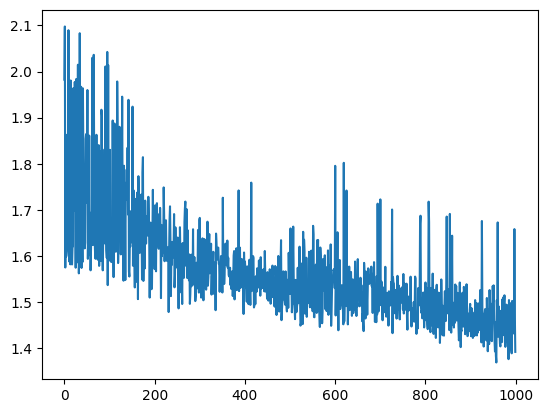

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(training_logs["loss"])), training_logs["loss"])

In [10]:
test_data_source = {}
test_data_target = {}
test_data_conditions = {}
adata_test = sc.read("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test.h5ad")
source = adata_test[adata_test.obs["condition"] == "control"].obsm["X_pca"]
for cond in adata_test.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_test[adata_test.obs["condition"] == cond].obsm["X_pca"]
    condition_1 = adata_test[adata_test.obs["condition"] == cond].obsm["ecfp_drug_1"]
    condition_2 = adata_test[adata_test.obs["condition"] == cond].obsm["ecfp_drug_2"]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(
        np.concatenate((condition_1[0, :][None, :], condition_2[0, :][None, :]), axis=0), axis=0
    )
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    test_data_source[cond] = source
    test_data_target[cond] = target
    test_data_conditions[cond] = conds

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [11]:
test_data_source_tiled = jax.tree_util.tree_map(lambda x: jnp.tile(jnp.expand_dims(x, 1), (1, 2, 1)), test_data_source)

In [15]:
predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source_tiled, test_data_conditions)

In [16]:
from ot_pert.metrics import compute_mean_metrics, compute_metrics_fast

In [17]:
metrics = jax.tree_util.tree_map(compute_metrics_fast, test_data_target, predicted_target_test)

In [18]:
compute_mean_metrics(metrics)

{'r_squared': 0.9526334842052073,
 'e_distance': 1.1838676804027275,
 'mmd_distance': 0.010763765451701253}

In [11]:
embs = jax.tree_util.tree_map(lambda x: vf.get_embedding(model.vf_state, x[0:1,...]), test_data_conditions)

In [25]:
test_data_conditions['Alvespimycin+Pirarubicin'][0:1, :, :].shape

(1, 2, 1024)

In [116]:
#compute_mean_metrics(metrics)

{'r_squared': 0.9505661802227665,
 'e_distance': 1.178403027925843,
 'mmd_distance': 0.01134050096761651}

In [117]:
ood_data_source = {}
ood_data_target = {}
ood_data_conditions = {}
adata_ood = sc.read("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood.h5ad")
source = adata_ood[adata_ood.obs["condition"] == "control"].obsm["X_pca"]
for cond in adata_ood.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_ood[adata_ood.obs["condition"] == cond].obsm["X_pca"]
    condition_1 = adata_ood[adata_ood.obs["condition"] == cond].obsm["ecfp_drug_1"]
    condition_2 = adata_ood[adata_ood.obs["condition"] == cond].obsm["ecfp_drug_2"]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(
        np.concatenate((condition_1[0, :][None, :], condition_2[0, :][None, :]), axis=0), axis=0
    )
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    ood_data_source[cond] = source
    ood_data_target[cond] = target
    ood_data_conditions[cond] = conds

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [118]:
ood_data_source_tiled = jax.tree_util.tree_map(lambda x: jnp.tile(jnp.expand_dims(x, 1), (1, 2, 1)), ood_data_source)

In [119]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source_tiled, ood_data_conditions)

In [120]:
metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)

In [121]:
compute_mean_metrics(metrics)

{'r_squared': 0.4976348736007222,
 'e_distance': 14.759638180738397,
 'mmd_distance': 0.031664483016373646}